In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.autonotebook import tqdm
from gpzoo.kernels import RBF
from gpzoo.gp import VNNGP, SVGP, GaussianLikelihood

/tmp/ipykernel_1190473/2937773115.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
N = 10000
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))

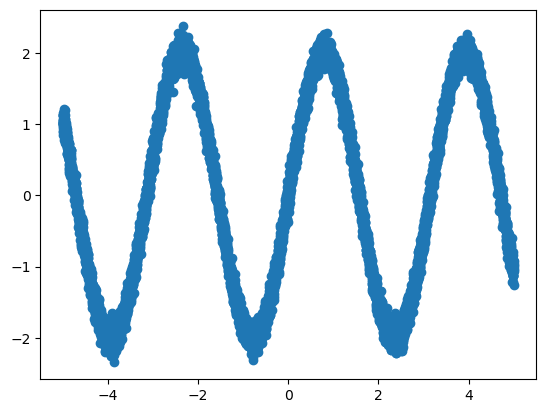

In [4]:
plt.scatter(X, y)

In [5]:
M = 1000
kernel = RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)

In [6]:
model.to(device)

GaussianLikelihood(
  (gp): VNNGP(
    (kernel): RBF()
  )
)

In [7]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [8]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses

In [9]:
model.gp.K = 5

In [10]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-2)

In [11]:
losses = fit(model, X_train, y_train, optimizer, epochs=2000, E=200)

  0%|          | 0/2000 [00:00<?, ?it/s]

finished Training


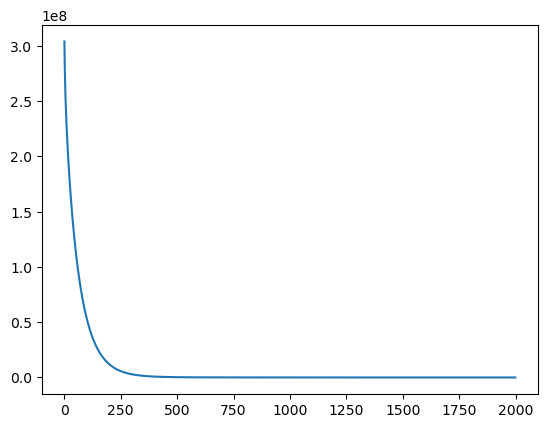

In [12]:
plt.plot(losses)

In [13]:
X_test = torch.linspace(-12, 12, 10000)

In [14]:
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=True)
mean_test = qF.mean.detach().cpu()

calculating Kxx
Kxx.shape torch.Size([10000, 1])
calculating Kxz
Kxz.shape torch.Size([10000, 1000])
calculating kzz
Kzz.shape torch.Size([1, 1000, 1000])
calculating L
L.shape torch.Size([1, 1000, 1000])
Little_L.shape: torch.Size([1, 10000, 5, 1000])
W_shape: torch.Size([10000, 1, 5])
torch.Size([10000, 1]) torch.Size([10000, 5, 5]) torch.Size([10000, 1, 5]) torch.Size([10000, 5]) torch.Size([10000, 5, 5])
mean.shape: torch.Size([10000, 1, 1])
cov.shape: torch.Size([10000, 1])


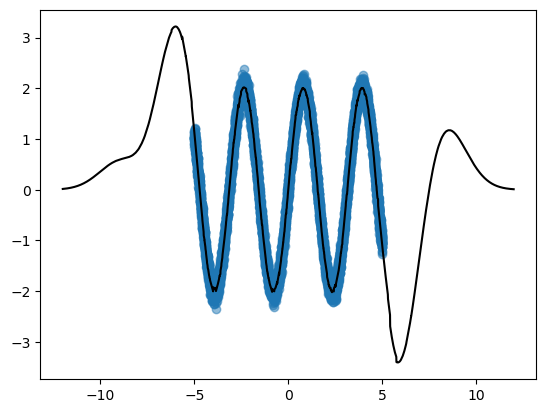

In [15]:
plt.plot(X_test, mean_test, color='black')
plt.scatter(X, y, alpha=0.5)

In [16]:
model.gp.kernel.lengthscale

Parameter containing:
tensor(1.4040, device='cuda:0', requires_grad=True)

In [17]:
model.gp.kernel.sigma

Parameter containing:
tensor(2.3338, device='cuda:0', requires_grad=True)

In [18]:
model.noise

Parameter containing:
tensor(0.3382, device='cuda:0', requires_grad=True)